In [ ]:
%pip install "python-doctr[torch]"

In [4]:
import os
import tarfile
import json

import torch
import numpy as np

from doctr.io import DocumentFile
from doctr.models import db_resnet50, ocr_predictor

os.environ['USE_TORCH'] = '1'

In [9]:
torch.__version__

'2.0.1'

In [92]:
import doctr

In [93]:
doctr.__version__

'v0.7.0'

## Configure PyTorch and GPU

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Pytorch cuda available: {torch.cuda.is_available()}")
print(f"Pytorch cuda current device: {torch.cuda.current_device()}")
print(f"Number of GPUs available: {torch.cuda.device_count()}")
print(f"Device Name: {torch.cuda.get_device_name(0)}")

Pytorch cuda available: True
Pytorch cuda current device: 0
Number of GPUs available: 1
Device Name: Tesla V100-SXM2-16GB


## Test and save pre-trained model

In [6]:
model = db_resnet50(pretrained=True)
predictor = ocr_predictor(det_arch=model, pretrained=True).cuda().half()

#### Validate our model/predictor is on CUDA

In [7]:
print(f"Model is on CUDA: {next(predictor.parameters()).is_cuda}")

Model is on CUDA: True


In [8]:
doc = DocumentFile.from_pdf("./sample_data/sample_2.pdf")
result = predictor(doc)

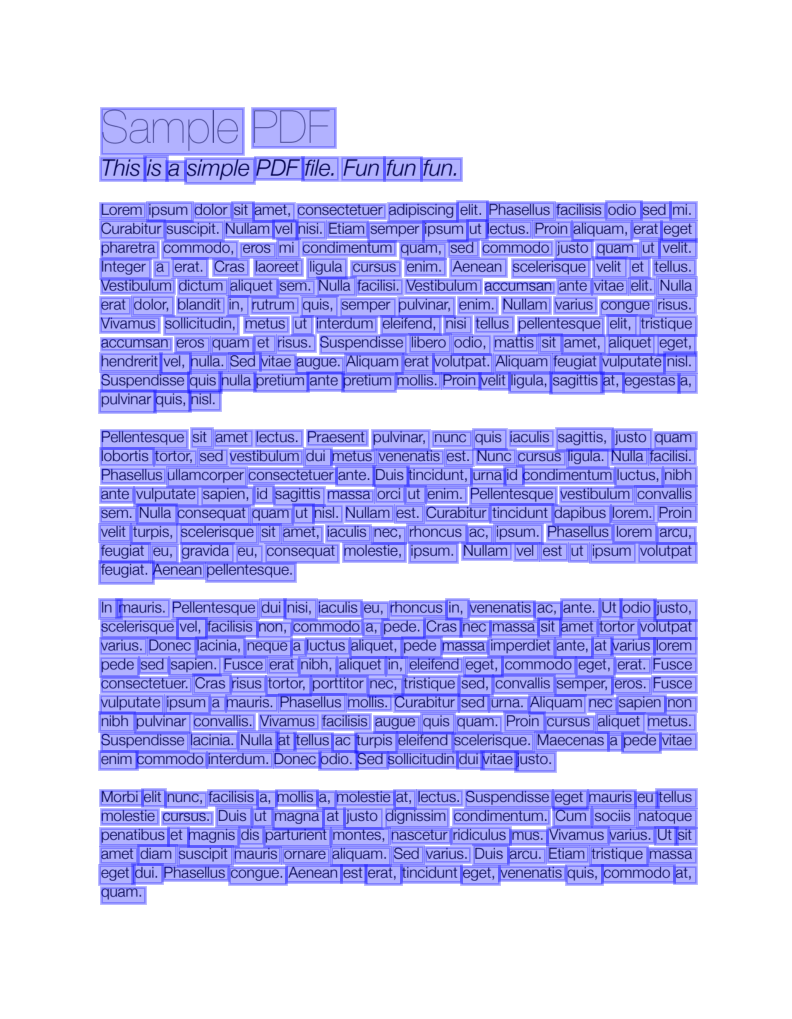

In [10]:
result.show(doc)

### Save Model

In [11]:
torch.save(model.state_dict(), "model.pth")

In [14]:
detection_model = db_resnet50(pretrained=False, pretrained_backbone=False)
det_params = torch.load('model.pth', map_location=device)
detection_model.load_state_dict(det_params)
new_predictor = ocr_predictor(det_arch=detection_model, pretrained=True).cuda().half()

In [15]:
print(f"New predictor is on CUDA: {next(new_predictor.parameters()).is_cuda}")
result = new_predictor(doc)

New predictor is on CUDA: True


# Deploy on SageMaker

## Prep model package structure

In [59]:
code_path = "code"
model_path = "model.pth"

if not os.path.exists(code_path):
    os.mkdir(code_path)

## Save the model if you did not run test cells above

In [60]:
model = db_resnet50(pretrained=True).cuda().half()
# model = db_resnet50(pretrained=True)
print(f"Model is on CUDA: {next(model.parameters()).is_cuda}")
torch.save(model.state_dict(), model_path)

Model is on CUDA: True


## Prepare Inference Code

### Add additional dependencies

In [61]:
additional_dependencies = [
    "python-doctr[torch]"
]

with open(f"{code_path}/requirements.txt", "w") as file:
    for dependency in additional_dependencies:
        file.write(f"{dependency}\n")

### Add the inference code

## TODO: ADD GPU

In [80]:
%%writefile ./code/inference.py
import torch

import json
import sys
import logging

from doctr.io import DocumentFile
from doctr.models import db_resnet50, ocr_predictor

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def model_fn(model_dir):
    """
    Load the model for inference
    """
    
    try:
        assert torch.cuda.is_available()
        
        model_path = f"{model_dir}/model.pth"
        model = db_resnet50(pretrained=False, pretrained_backbone=False).cuda().half()
        model_params = torch.load(model_path)
        model.load_state_dict(model_params)

        logger.debug("Successfully Loaded the Model")
        return model
    except Exception as e:
        logger.error(f"Unable to load model: {e}")
        raise
    


def predict_fn(input_data, model):
    """
    Apply model to incoming requests
    """
    
    try:
        predictor = ocr_predictor(det_arch=model, pretrained=True).cuda().half()
        result = predictor(input_data)
        predictor.to(device)
        
        logger.debug(f"Predictor is using GPU: {next(predictor.parameters()).is_cuda}")
        logger.debug("Successfully generated predictions")
        return result
    except Exception as e:
        logger.error(f"Unable to generate predictions: {e}")
        raise

    


def input_fn(request_body, request_content_type):
    """
    Deserialize and prepare the prediction input
    """
    
    try:
        if request_content_type == "application/pdf":
            request = DocumentFile.from_pdf(bytes(request_body))
        else:
            raise Exception("This predictor only supports pdf data")

        logger.debug("Successfully deserialised input")
        logger.debug(f"Type of deserialized data: {type(request)}")
        return request
    except Exception as e:
        logger.error(f"Unable to deserialize input: {e}")
        raise
    



def output_fn(prediction, response_content_type):
    """
    Serialize and prepare the prediction output
    """
    try: 
        if response_content_type == "application/json":
            response = json.dumps(prediction.export())
        else:
            response = str(prediction.export())

        logger.debug("Successfully serialized output")
        logger.debug(f"Type of serialized output: {type(response)}")
        
        return response
    
    except Exception as e:
        logger.error(f"Unable to serialize output: {e}")
        raise

Overwriting ./code/inference.py


### Package Model

In [81]:
zipped_model_path = "model.tar.gz"

with tarfile.open(zipped_model_path, "w:gz") as tar:
    tar.add(model_path)
    tar.add(code_path)

### Deploy to SageMaker

In [82]:
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role
import sagemaker as sage
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

endpoint_name = "resnet50-doc-processing-gpu"

model = PyTorchModel(
    entry_point="inference.py",
    source_dir="code",
    model_data=zipped_model_path,
    role=get_execution_role(),
    framework_version="2.0.1",
    py_version="py310",
)

In [84]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.p3.2xlarge",
    endpoint_name=endpoint_name,
    serializer=IdentitySerializer(content_type="application/pdf"),
    deserializer=JSONDeserializer()
)

----------!

## Invoke endpoint

In [85]:
sm = sage.Session().sagemaker_runtime_client

In [86]:
with open("./sample_data/sample_2.pdf", "rb") as pdf_file:
    pdf_data = pdf_file.read()

In [91]:
response = sm.invoke_endpoint(
    EndpointName=endpoint_name, Body=pdf_data, ContentType="application/pdf", Accept="application/json"
)

response["Body"].read()

b'{"pages": [{"page_idx": 0, "dimensions": [1584, 1224], "orientation": {"value": null, "confidence": null}, "language": {"value": null, "confidence": null}, "blocks": [{"geometry": [[0.11707261029411764, 0.0986328125], [0.42038143382352944, 0.14453125]], "lines": [{"geometry": [[0.11707261029411764, 0.0986328125], [0.42038143382352944, 0.14453125]], "words": [{"value": "Sampe", "confidence": 0.5771484375, "geometry": [[0.11707261029411764, 0.0986328125], [0.30158547794117646, 0.14453125]]}, {"value": "PDF", "confidence": 0.81201171875, "geometry": [[0.31295955882352944, 0.0986328125], [0.42038143382352944, 0.1376953125]]}]}], "artefacts": []}, {"geometry": [[0.11580882352941174, 0.146484375], [0.5834099264705882, 0.173828125]], "lines": [{"geometry": [[0.11580882352941174, 0.146484375], [0.5834099264705882, 0.173828125]], "words": [{"value": "This", "confidence": 0.9736328125, "geometry": [[0.11580882352941174, 0.1474609375], [0.17394301470588236, 0.1708984375]]}, {"value": "i\\u00cf"